# ANÁLISIS PARTE II

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [13]:
# Cargar datos económicos
# Asegúrate de tener estos archivos en tu carpeta
df_costes = pd.read_csv('../data/processed/CO614_costes_estructura_clean.csv')
df_precios = pd.read_csv('../data/processed/CO497_indice_precios_clean.csv')

print("Datos Económicos Cargados:")
print(f"- Costes (Filas): {df_costes.shape[0]}")
print(f"- Precios (Filas): {df_precios.shape[0]}")

Datos Económicos Cargados:
- Costes (Filas): 2080
- Precios (Filas): 40


## Desglose de Costes
### ¿En qué se gasta el dinero un transportista?

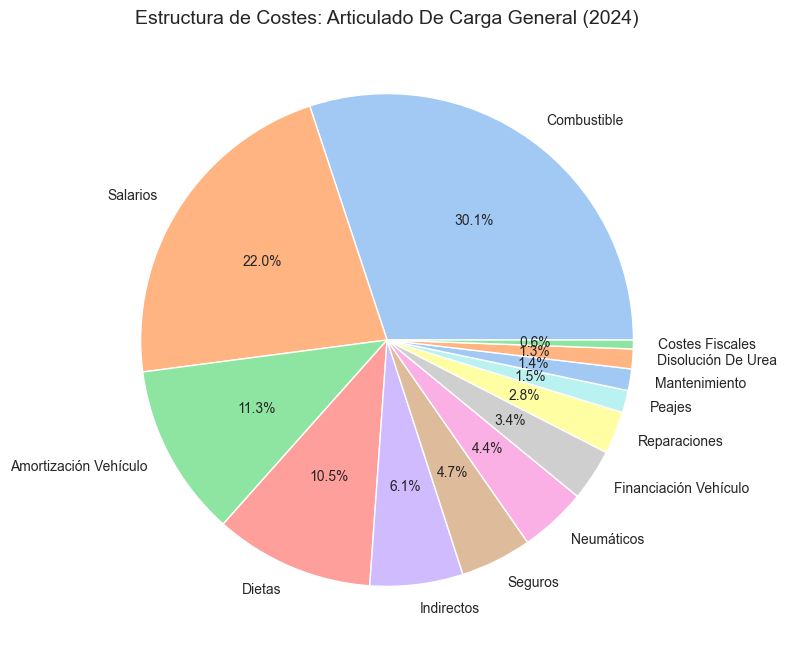

In [14]:
# 1. Filtramos datos recientes y tipo de vehículo común
anio_max = df_costes['Año'].max()
filtro_vehiculo = "Articulado De Carga General"

df_2024 = df_costes[
    (df_costes['Año'] == anio_max) & 
    (df_costes['Vehículo'] == filtro_vehiculo) &
    (df_costes['Tipo Costes'] != 'Costes Totales') # Evitamos duplicar el total
]

# 2. Agrupamos por concepto de coste
# Usamos 'Subcategoría Costes' para ver detalle (Combustible, Personal, etc.)
desglose_costes = df_2024.groupby('Tipo Costes')['Costes Anuales'].sum().sort_values(ascending=False)

# 3. Visualizamos
plt.figure(figsize=(10, 8))
colores = sns.color_palette('pastel')
plt.pie(desglose_costes, labels=desglose_costes.index, autopct='%1.1f%%', colors=colores)
plt.title(f'Estructura de Costes: {filtro_vehiculo} ({anio_max})', fontsize=14)
plt.show()

## Evolución Coste vs Precio
### ¿Se repercute la subida de costes a los clientes?

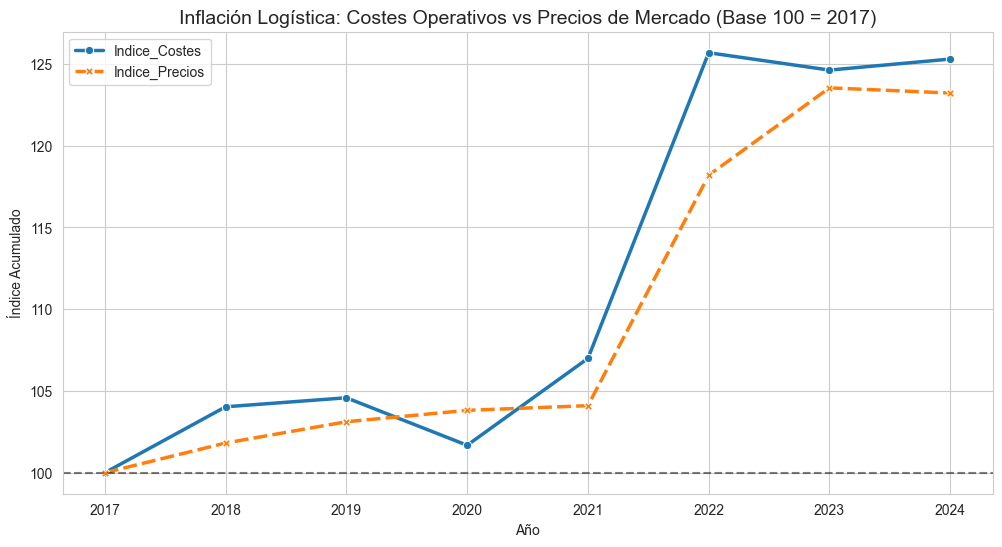

In [15]:
# 1. Preparar Costes: Suma total por año para el vehículo estándar
evolucion_costes = df_costes[df_costes['Vehículo'] == filtro_vehiculo].groupby('Año')['Costes Anuales'].sum()
# Normalizamos a base 100 para comparar (Año 2017 = 100)
base_coste = evolucion_costes.iloc[0]
indice_costes = (evolucion_costes / base_coste) * 100

# 2. Preparar Precios: Promedio del índice de precios por año
# El archivo CO497 ya trae un 'Índice Variación', pero vamos a reconstruir un índice base 100 aproximado
# Ojo: CO497 tiene precios medios en euros. Usaremos el precio medio total por año.
evolucion_precios = df_precios.groupby('Año')['Precio Medio'].mean()
base_precio = evolucion_precios.iloc[0]
indice_precios = (evolucion_precios / base_precio) * 100

# 3. Unir en un solo DataFrame para graficar
df_comparativo = pd.DataFrame({
    'Indice_Costes': indice_costes,
    'Indice_Precios': indice_precios
})

# 4. Gráfico de Líneas Comparativo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_comparativo, markers=True, linewidth=2.5)

plt.title('Inflación Logística: Costes Operativos vs Precios de Mercado (Base 100 = 2017)', fontsize=14)
plt.ylabel('Índice Acumulado')
plt.axhline(100, color='black', linestyle='--', alpha=0.5) # Línea base
plt.show()

In [16]:
df_comparativo.reset_index().to_csv('../data/processed/KPI_Costes_vs_Precios.csv', index=False)
print("✅ KPI Económico guardado.")

✅ KPI Económico guardado.
